<a href="https://colab.research.google.com/github/adityasaich/sasi_btp/blob/main/sasi_btp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id = '18xGNPuvbXGSN97g0CzI1tIBl81zJrToF'

In [27]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset.csv')  
df_input = pd.read_csv('dataset.csv')
#df_input = df_input.sample(n=50000)

In [ ]:
#url = 'https://raw.githubusercontent.com/adityasaich/sasi_btp/main/dataworld_set.csv?token=ALPKPQCX3COGEIP65QDO2V3BR5QT6'
#df_input = pd.read_csv(url)

In [28]:
def deviationTransform(arr):
  m = np.mean(arr)
  d = np.std(arr)
  return [0,d]
def minMaxTransform(arr):
  min = np.min(arr)
  max = np.max(arr)
  return [min,max-min]

In [29]:
#pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
df_input = df_input[df_input['Area'] > 0 ]
df_input = df_input[df_input['Production'] > 0 ]
df_input["ProductionPerArea"] = ((df_input["Production"])/(df_input["Area"]))
#dropping columns which are not used
df_input = df_input.drop(columns=['State_Name','Area','Production'])
#replace empty strings with nan
df_input = df_input.replace(r'^\s*$', np.NaN, regex=True)
#drop null values
df_input = df_input.dropna()


count    238838.000000
mean         42.263407
std         823.564866
min           0.000003
25%           0.532242
50%           1.000000
75%           2.400000
max       88000.000000
Name: ProductionPerArea, dtype: float64


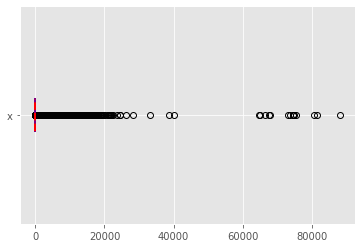

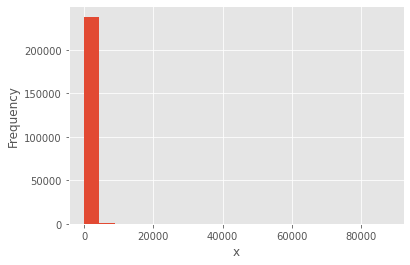

In [7]:
x = df_input['ProductionPerArea']
print(x.describe())

import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots()
ax.boxplot((x), vert=False, showmeans=True, meanline=True,
           labels=('x'), patch_artist=True,
           medianprops={'linewidth': 2, 'color': 'purple'},
           meanprops={'linewidth': 2, 'color': 'red'})
plt.show()
hist, bin_edges = np.histogram(x, bins=20)
fig, ax = plt.subplots()
ax.hist(x, bin_edges, cumulative=False)
ax.set_xlabel('x')
ax.set_ylabel('Frequency')
plt.show()

In [30]:
categorical_columns = ['District_Name', 'Crop' ,'Season']
#label encoder dict
labels_dict = {}
#scaling dict
scaling_dict = {}
for column in categorical_columns:
  le = LabelEncoder()
  le.fit(df_input[column])
  df_input[column] = le.transform(df_input[column])
  labels_dict[column] = list(le.classes_)
  scaling_params = minMaxTransform(np.array(df_input[column]))
  df_input[column] = (df_input[column] - scaling_params[0])/scaling_params[1]
  scaling_dict[column] = scaling_params
scaling_params = deviationTransform(np.array(df_input['Crop_Year'])) 
scaling_dict['Crop_Year'] = scaling_params
df_input['Crop_Year'] = (df_input['Crop_Year'] - scaling_params[0])/scaling_params[1]
scaling_params = deviationTransform(np.array(df_input['ProductionPerArea']))
df_input['ProductionPerArea'] = (df_input['ProductionPerArea'] - scaling_params[0])/scaling_params[1]
scaling_dict['ProductionPerArea'] = scaling_params
p1 = np.percentile(np.array(df_input['ProductionPerArea']),25)
p2 = np.percentile(np.array(df_input['ProductionPerArea']),99)
df_input = df_input[df_input['ProductionPerArea'] > p1]
df_input = df_input[df_input['ProductionPerArea'] < p2]

In [ ]:
df_input

,District_Name,Crop_Year,Season,Crop,ProductionPerArea
0,0.662016,401.972771,0.2,0.009615,0.001937
2,0.662016,401.972771,0.2,0.769231,0.003821
3,0.662016,401.972771,0.8,0.048077,0.004422
6,0.662016,401.972771,0.8,0.317308,0.003373
7,0.662016,401.972771,0.8,0.865385,0.002428
...,...,...,...,...,...
246085,0.730233,404.786580,0.6,0.500000,0.007618
246086,0.730233,404.786580,0.6,0.769231,0.003178
246087,0.730233,404.786580,0.6,0.836538,0.000897
246088,0.730233,404.786580,0.8,0.865385,0.060899


In [9]:
from sklearn.model_selection import train_test_split
df_small = df_input
df_small.columns.name = None
df=df_small
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.33, random_state=42)

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def classify(clf,x_train,x_test,y_train,y_test):
  clf.fit(x_train,y_train)
  y_pred = clf.predict(x_test)
  print(y_pred)
  y_train_pred = clf.predict(x_train)
  metricsList = []
  metricsList.append(mean_squared_error(y_train, y_train_pred))
  metricsList.append(mean_absolute_error(y_test, y_pred))
  metricsList.append(np.sqrt(mean_squared_error(y_test, y_pred)))
  metricsList.append(r2_score(y_test,y_pred))
  y_pred = np.array(y_pred)
  y_test = np.array(y_test)
  for i in range(y_test.size):
    if(y_test[i]>15):
      print(i,y_test[i],y_pred[i])
  data={}
  data['x'] = y_test
  data['y'] = y_pred
  #sns.regplot(x="x", y="y", data=data);
  return metricsList


In [32]:
clfMetrics = []

In [33]:
from sklearn.ensemble import RandomForestRegressor
regresser = RandomForestRegressor(n_estimators = 10 ,random_state = 0)
print("\t\t\t random-forest classifier")
clfMetrics.append((classify(regresser,x_train,x_test,y_train,y_test)))
print(clfMetrics)

			 random-forest classifier
[0.00158803 0.00304108 0.0008977  ... 0.07668878 0.00342747 0.06396993]
[[3.7124307254060725e-06, 0.0015127300089711254, 0.004453244017675656, 0.8838874164467735]]


In [ ]:
regresser.get_params("true")

In [34]:
#linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
print("\t\t\t linear-regression classifier")
clfMetrics.append((classify(reg,x_train,x_test,y_train,y_test)))
print(clfMetrics)

			 linear-regression classifier
[0.00804721 0.01322361 0.00507802 ... 0.01250506 0.01038391 0.01274328]
[[3.7124307254060725e-06, 0.0015127300089711254, 0.004453244017675656, 0.8838874164467735], [0.00015706748090237865, 0.006590277513631465, 0.012385990235560354, 0.10176956008491334]]


In [35]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
K = 3
model = neighbors.KNeighborsRegressor(n_neighbors = K)
clfMetrics.append((classify(model,x_train,x_test,y_train,y_test)))
print(clfMetrics)

[0.00165927 0.01675481 0.00091038 ... 0.0736773  0.00364343 0.06392402]
[[3.7124307254060725e-06, 0.0015127300089711254, 0.004453244017675656, 0.8838874164467735], [0.00015706748090237865, 0.006590277513631465, 0.012385990235560354, 0.10176956008491334], [3.905524299211639e-05, 0.0037482670396252037, 0.00914529419235706, 0.5103095171845271]]


In [ ]:
json_params = {}
json_params['labels'] = labels_dict
json_params['scaling'] = scaling_dict

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

        MSE       MAE      RMSE  R2_Score             models
0  0.000004  0.001513  0.004453  0.883887      Random Forest
1  0.000157  0.006590  0.012386  0.101770  Linear Regression
2  0.000039  0.003748  0.009145  0.510310      KNN regressor


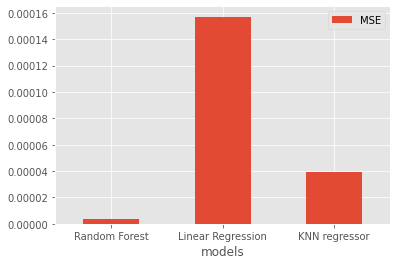

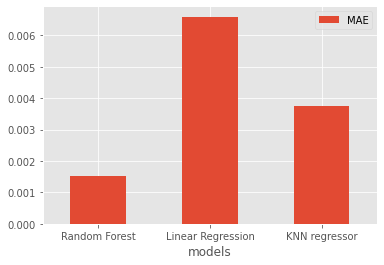

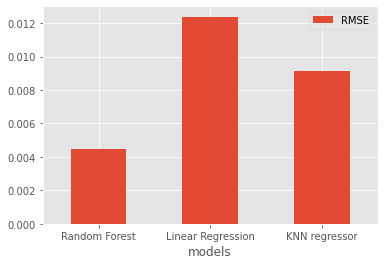

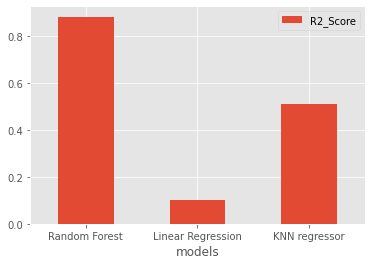

In [46]:
df = pd.DataFrame.from_records(clfMetrics)
metricList = ['MSE','MAE','RMSE','R2_Score']
df.columns= metricList
df['models'] = ['Random Forest','Linear Regression' ,'KNN regressor']
print(df)
for metric in metricList:
  df.plot.bar(x='models', y=metric, rot=0)

In [38]:
pd.DataFrame({'lab':['A', 'B', 'C'], 'val':[10, 30, 20]})

,lab,val
0,A,10
1,B,30
2,C,20
